In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

## Análisis exploratorio de la data:
Se incluyen las 3 tablas de producto, demographic info y transacciones.

Se desplegó el head de cada tabla por propósitos ilustrativos.


In [65]:
product_df = pd.read_csv("product.csv")
transaction_df = pd.read_csv("transaction.csv")
demographics_df = pd.read_csv("demographic.csv")

print(" PRODUCT HEAD: ")
print(product_df.head(),"\n")

print(" TRANSACTIONS HEAD: ")
print(transaction_df.head(), '\n')

print(" DEMOGRAPHICS HEAD: ")
print(demographics_df.head(), "\n")

 PRODUCT HEAD: 
   PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC
0       25671             2       GROCERY  National                  FRZN ICE
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION
2       26093            69        PASTRY   Private                     BREAD
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE
4       26355            69       GROCERY   Private             COOKIES/CONES 

 TRANSACTIONS HEAD: 
   household_key    BASKET_ID  PRODUCT_ID  QUANTITY  SALES_VALUE  STORE_ID  \
0           2375  26984851472     1004906         1         1.39       364   
1           2375  26984851472     1033142         1         0.82       364   
2           2375  26984851472     1036325         1         0.99       364   
3           2375  26984851472     1082185         1         1.21       364   
4           2375  26984851472     8160430         1         1.50       364   

   WEEK_NO  
0        1 

In [63]:
print(" PRODUCT INFO: ")
product_df.info()

print("\n TRANSACTION INFO: ")
transaction_df.info()

print("\n DEMOGRAPHICS INFO: ")
demographics_df.info()

 PRODUCT INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PRODUCT_ID      92353 non-null  int64 
 1   MANUFACTURER    92353 non-null  int64 
 2   DEPARTMENT      92353 non-null  object
 3   BRAND           92353 non-null  object
 4   COMMODITY_DESC  92353 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.5+ MB

 TRANSACTION INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 2 columns):
 #   Column           Dtype
---  ------           -----
 0   household_key    int64
 1   last_occurrence  int64
dtypes: int64(2)
memory usage: 39.6 MB

 DEMOGRAPHICS INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_D

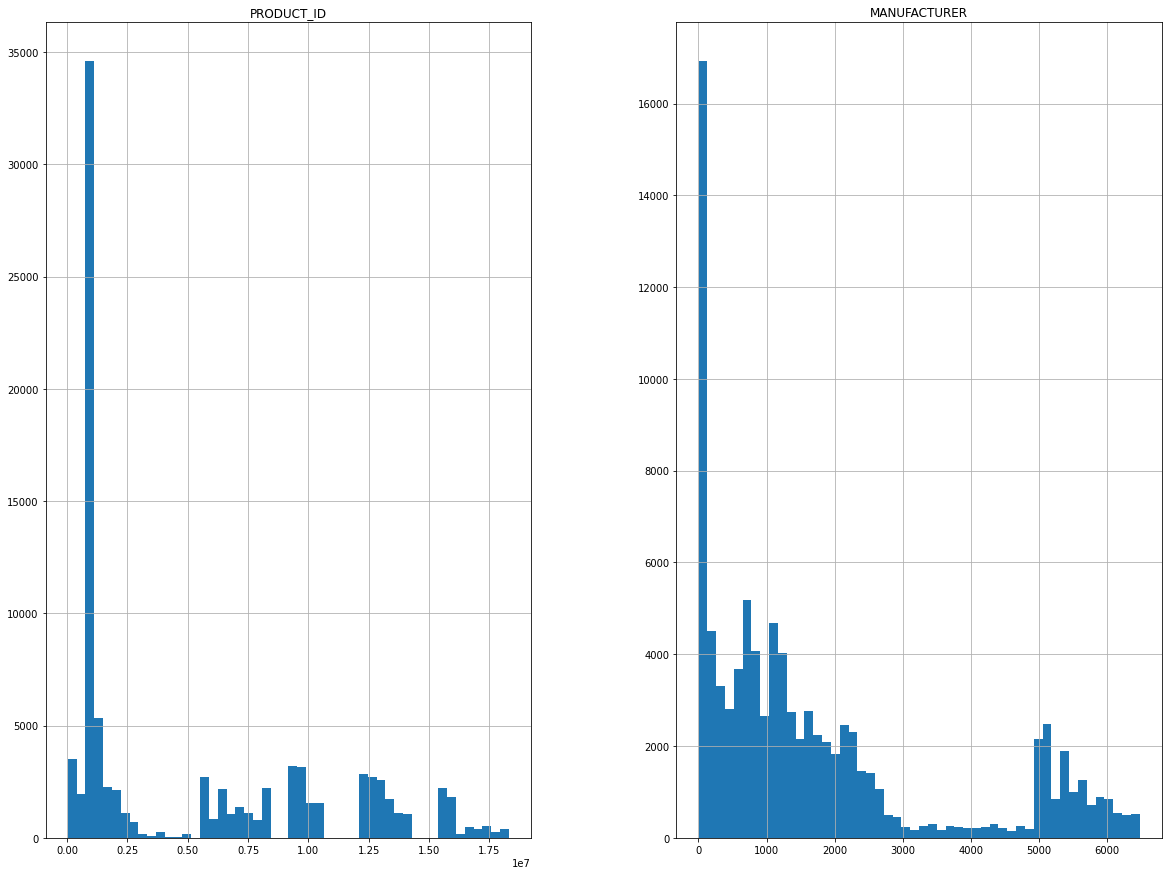

In [64]:
# Histogramas para la data de producto.
product_df.hist(bins=50, figsize=(20,15))
plt.show()

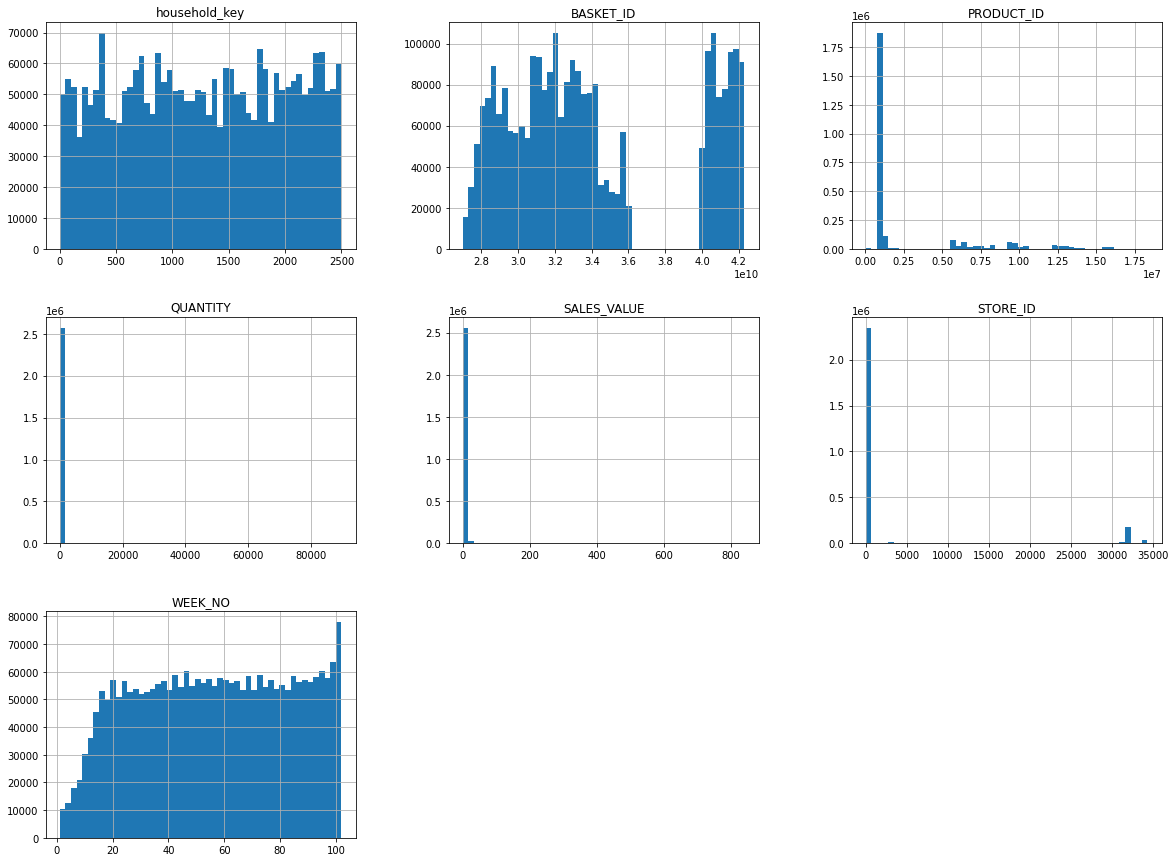

In [66]:
# Histogramas para la data de transacciones.
transaction_df.hist(bins=50, figsize=(20,15))
plt.show()

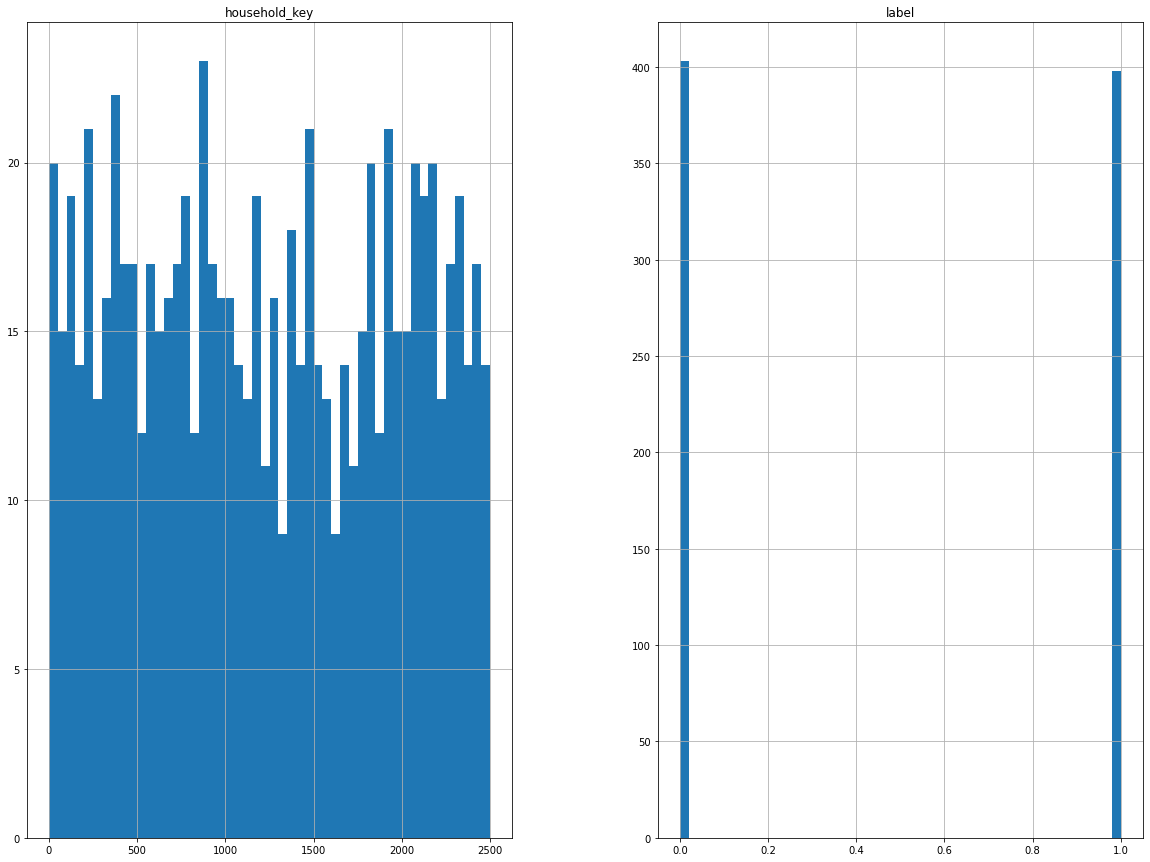

In [67]:
# Histogramas para la data de la data demografica.
demographics_df.hist(bins=50, figsize=(20,15))
plt.show()

### Se verificó que tipo de datos contienen las tablas.

Pude percibir basado en los tipos de variables cuáles eran las más útiles para poder evaluar un método de clustering en el futuro.

Variables cuantitativas que defini importantes: QUANTITY y SALES_VALUE

Identifique opciones de ingenieria de datos y genera un conteo de las transacciones, tiends visitadas, cantidad de veces visitadas y frequencia de visita para crear el custumer dna.



In [24]:
# Primero creo una tabla basada en la data demografica vs las transacciones
customer_by_trans = pd.merge(demographics_df, transaction_df, how='outer')
customer_by_trans.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,household_key,label,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,WEEK_NO
0,65+,A,35-49K,1,0.0,27601281299,825123,1,3.99,436,8
1,65+,A,35-49K,1,0.0,27601281299,831447,1,2.99,436,8
2,65+,A,35-49K,1,0.0,27601281299,840361,1,1.09,436,8
3,65+,A,35-49K,1,0.0,27601281299,845307,1,3.71,436,8
4,65+,A,35-49K,1,0.0,27601281299,852014,1,2.79,436,8


In [25]:
# Proceso de ETL para poder construir el custumer DNA
customer_by_trans = customer_by_trans.groupby("household_key").sum()
customer_by_trans.head()

,label,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,WEEK_NO
household_key,,,,,,,
1,0.0,59011300789841,5274477372,1997,4330.16,1031657,98412
2,0.0,24211166961791,2138870077,834,1954.34,8242337,39661
3,0.0,29353603004438,2513054814,8540,2653.21,359263,40753
4,0.0,9456388695009,813525920,382,1200.11,93964,11918
5,0.0,6962167980793,677228224,245,779.06,106344,8911


In [26]:
# Cambiar la tabla a un data Frame y eliminar columnas que has sido sujetas de adicion
df = pd.DataFrame(customer_by_trans)

# Dropping jobs
df.drop(['STORE_ID'], axis='columns', inplace=True)
df.drop(['WEEK_NO'], axis='columns', inplace=True)
df.drop(['PRODUCT_ID'], axis='columns', inplace=True)
df.drop(['BASKET_ID'], axis='columns', inplace=True)
df.drop(['label'], axis='columns', inplace=True)
df.head()

,QUANTITY,SALES_VALUE
household_key,,
1,1997,4330.16
2,834,1954.34
3,8540,2653.21
4,382,1200.11
5,245,779.06


### Construccion de costumer DNA
En este proceso creare una tabla que utilize un merge de las 3 creando un perfil por cliente.

Para esto debo resumir la tabla a KPIS especificos, uno sera la suma de los valores por cliente y luego por categoria de producto.

In [28]:
# Concatenacion de tablas de transacciones y de clientes
custumer_dna = pd.merge(df, transaction_df, how='left', on='household_key')

In [29]:
custumer_dna.head()

,household_key,QUANTITY_x,SALES_VALUE_x,BASKET_ID,PRODUCT_ID,QUANTITY_y,SALES_VALUE_y,STORE_ID,WEEK_NO
0,1,1997,4330.16,27601281299,825123,1,3.99,436,8
1,1,1997,4330.16,27601281299,831447,1,2.99,436,8
2,1,1997,4330.16,27601281299,840361,1,1.09,436,8
3,1,1997,4330.16,27601281299,845307,1,3.71,436,8
4,1,1997,4330.16,27601281299,852014,1,2.79,436,8


In [30]:
# Agrupacion por id de cliente
custumer_dna = custumer_dna.groupby('household_key').nunique()
custumer_dna.head()

,QUANTITY_x,SALES_VALUE_x,BASKET_ID,PRODUCT_ID,QUANTITY_y,SALES_VALUE_y,STORE_ID,WEEK_NO
household_key,,,,,,,,
1,1,1,86,677,7,270,2,68
2,1,1,45,546,6,199,5,35
3,1,1,47,516,14,237,3,37
4,1,1,30,164,7,101,6,26
5,1,1,40,199,3,95,3,27


In [32]:
# eliminar columnas innecesarias
custumer_dna.drop(['QUANTITY_x', 'QUANTITY_y', 'SALES_VALUE_x', 'SALES_VALUE_y'], axis='columns', inplace=True)
custumer_dna.head()

,BASKET_ID,PRODUCT_ID,STORE_ID,WEEK_NO
household_key,,,,
1,86,677,2,68
2,45,546,5,35
3,47,516,3,37
4,30,164,6,26
5,40,199,3,27


In [34]:
# Concatenar el data frame de sales value y cantidad al custuemr dna que se esta creando
custumer_dna = pd.merge(custumer_dna, df, on='household_key', how='left')
custumer_dna.head()

,BASKET_ID,PRODUCT_ID,STORE_ID,WEEK_NO,QUANTITY,SALES_VALUE
household_key,,,,,,
1,86,677,2,68,1997,4330.16
2,45,546,5,35,834,1954.34
3,47,516,3,37,8540,2653.21
4,30,164,6,26,382,1200.11
5,40,199,3,27,245,779.06


In [35]:
# Cambiar el nombre del campo por propositos de analisis
custumer_dna.rename(columns={'BASKET_ID': 'Transaction_Count'}, inplace=True)
custumer_dna.head()

,Transaction_Count,PRODUCT_ID,STORE_ID,WEEK_NO,QUANTITY,SALES_VALUE
household_key,,,,,,
1,86,677,2,68,1997,4330.16
2,45,546,5,35,834,1954.34
3,47,516,3,37,8540,2653.21
4,30,164,6,26,382,1200.11
5,40,199,3,27,245,779.06


In [36]:
# Cambiar el nombre del campo por propositos de analisis
custumer_dna.rename(columns={'PRODUCT_ID': 'Product_Count'}, inplace=True)
custumer_dna.head()

,Transaction_Count,Product_Count,STORE_ID,WEEK_NO,QUANTITY,SALES_VALUE
household_key,,,,,,
1,86,677,2,68,1997,4330.16
2,45,546,5,35,834,1954.34
3,47,516,3,37,8540,2653.21
4,30,164,6,26,382,1200.11
5,40,199,3,27,245,779.06


In [37]:
# Cambiar el nombre del campo por propositos de analisis
custumer_dna.rename(columns={'STORE_ID': 'Store_Visit_Count'}, inplace=True)
custumer_dna.head()

,Transaction_Count,Product_Count,Store_Visit_Count,WEEK_NO,QUANTITY,SALES_VALUE
household_key,,,,,,
1,86,677,2,68,1997,4330.16
2,45,546,5,35,834,1954.34
3,47,516,3,37,8540,2653.21
4,30,164,6,26,382,1200.11
5,40,199,3,27,245,779.06


In [38]:
# Cambiar el nombre del campo por propositos de analisis
custumer_dna.rename(columns={'WEEK_NO': 'Weeks_Visited_Count'}, inplace=True)
custumer_dna.head()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE
household_key,,,,,,
1,86,677,2,68,1997,4330.16
2,45,546,5,35,834,1954.34
3,47,516,3,37,8540,2653.21
4,30,164,6,26,382,1200.11
5,40,199,3,27,245,779.06


### Funcion para generar el campo de frecuencia

Tiene un proposito de feature engineering basado en el concepto de RFM (Recency, Frequency & Monetary value):

"RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries."

- https://en.wikipedia.org/wiki/RFM_(market_research)


In [59]:
def frequency(row):
    freq =  row['Weeks_Visited_Count'] / 24
    return freq

dna_copy = custumer_dna.copy()

In [60]:
dna_copy.apply (lambda row: frequency(row), axis=1)

household_key
1       2.833333
2       1.458333
3       1.541667
4       1.083333
5       1.125000
          ...   
2496    2.000000
2497    3.583333
2498    2.791667
2499    2.250000
2500    2.666667
Length: 2500, dtype: float64

In [61]:
# una vez generado el campo, incluirlo en el data frame
custumer_dna['frequency_ratio'] = custumer_dna.apply (lambda row: frequency(row), axis=1)

In [62]:
custumer_dna.head()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio
household_key,,,,,,,
1,86,677,2,68,1997,4330.16,2.833333
2,45,546,5,35,834,1954.34,1.458333
3,47,516,3,37,8540,2653.21,1.541667
4,30,164,6,26,382,1200.11,1.083333
5,40,199,3,27,245,779.06,1.125000


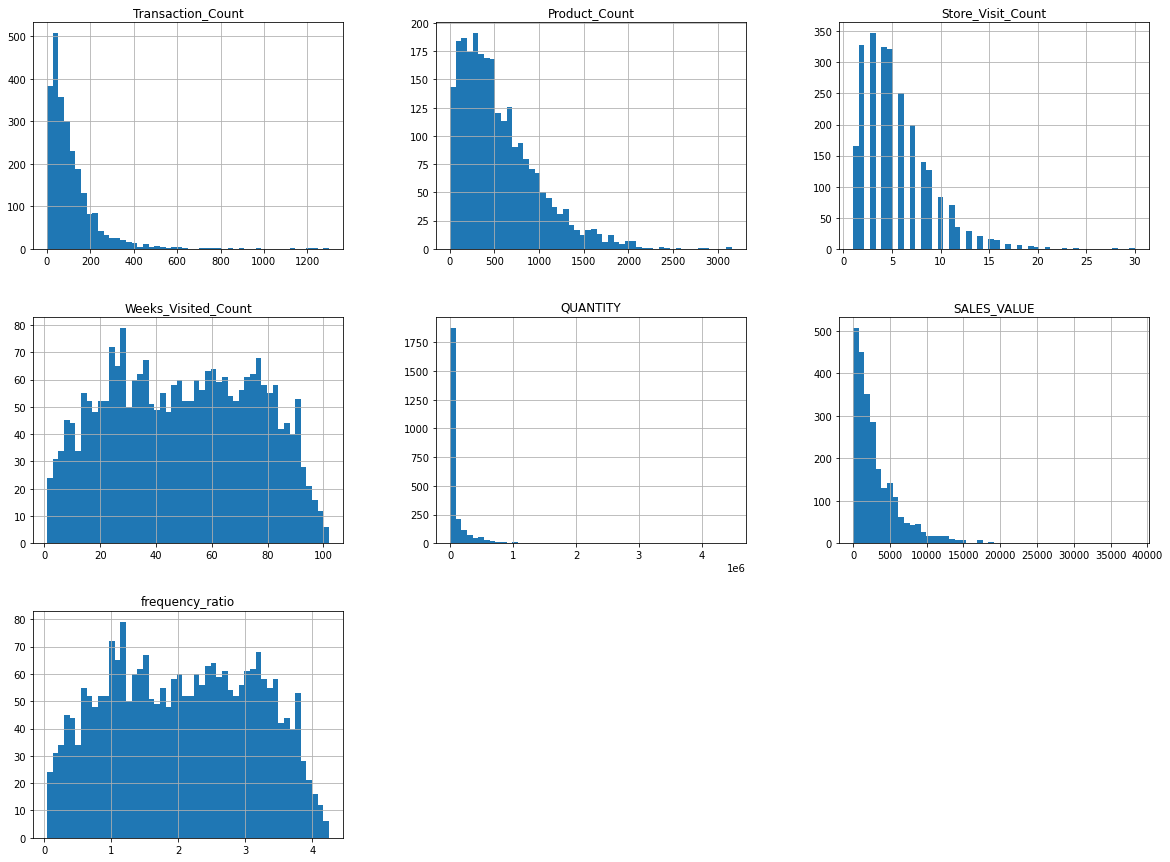

In [68]:
# Ahora que tengo el custumer DNA, evaluar como estan distribuidos los features
custumer_dna.hist(bins=50, figsize=(20,15))
plt.show()

## Construccion del modelo de ML

<AxesSubplot:xlabel='SALES_VALUE', ylabel='QUANTITY'>

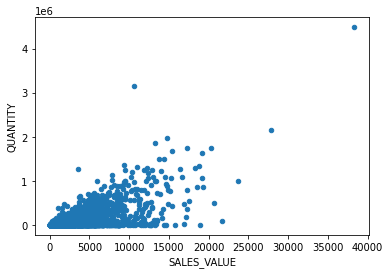

In [69]:
# Grafico de la data en relacion cantidad versus valor de ventas
%matplotlib inline
custumer_dna.plot.scatter(x='SALES_VALUE', y='QUANTITY')

### Modelo de clasificacion usando K-Means de la libreria de Scikit-Learn

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Para la construccion del modelo y evaluar el numero adecuado de clusters para el entrenamiento del modelo se utilizara el "elbow method" que consiste en ubicar el numero de clusters adecuados por medio del coeficiente de inercia.

In [70]:
custumer_dna.head()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio
household_key,,,,,,,
1,86,677,2,68,1997,4330.16,2.833333
2,45,546,5,35,834,1954.34,1.458333
3,47,516,3,37,8540,2653.21,1.541667
4,30,164,6,26,382,1200.11,1.083333
5,40,199,3,27,245,779.06,1.125000


In [71]:
clusters = range(1, 10)
inertia = []

# se hara un loop or el numero de clusters (10)
for i in clusters:
    model = KMeans(n_clusters = i)
    model.fit(custumer_dna[['QUANTITY', 'SALES_VALUE', 'frequency_ratio', 'Product_Count', 'Transaction_Count']])
    inertia.append(model.inertia_)

print(clusters)
print(inertia)

range(1, 10)
[149365710896154.88, 57380331742581.81, 31508035495794.113, 18238315051238.17, 11192071177008.328, 7445146971952.945, 5374159331210.632, 4479194254499.292, 3129947565413.129]


### Grafico del elbow method

Utilizando el grafico podremos evaluar cual es el numero optimo de clusters

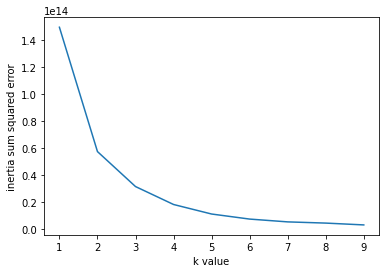

In [72]:
# Grafico basico del elbow method basado en mis cluster y la inercia generada por el modelo
plt.plot(clusters, inertia)
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')
plt.show()

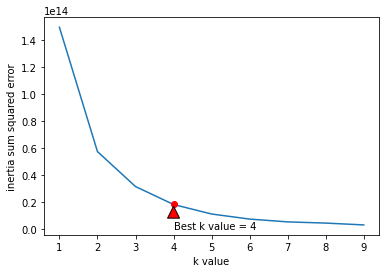

In [73]:
# Definicion y grafico del numero de clusters optimo
plt.plot(clusters, inertia)
plt.xlabel('k value')
plt.ylabel('inertia sum squared error')


plt.plot(clusters[3], inertia[3], 'ro')
plt.annotate('Best k value = 4', xy=(clusters[3], inertia[3]), xytext = (4, 30), arrowprops = dict(facecolor = 'red', shrink=0.1))
plt.show()

## Model fitting

Se usaran 4 clusters basado al analsis llevado

In [74]:
# K-Means model fit
model_KM = KMeans(n_clusters = 4, max_iter = 1000)
model_KM.fit(custumer_dna[['QUANTITY', 'SALES_VALUE', 'frequency_ratio', 'Product_Count', 'Transaction_Count']])

KMeans(max_iter=1000, n_clusters=4)

In [75]:
model_KM.labels_

array([0, 0, 0, ..., 0, 0, 2], dtype=int32)

### Predecir el cluster

In [76]:
custumer_dna['cluster'] = model_KM.predict(custumer_dna[['QUANTITY', 'SALES_VALUE', 'frequency_ratio', 'Product_Count', 'Transaction_Count']])
custumer_dna.head()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio,cluster
household_key,,,,,,,,
1,86,677,2,68,1997,4330.16,2.833333,0
2,45,546,5,35,834,1954.34,1.458333,0
3,47,516,3,37,8540,2653.21,1.541667,0
4,30,164,6,26,382,1200.11,1.083333,0
5,40,199,3,27,245,779.06,1.125000,0


In [77]:
# Se evalua la posicion de los centroids.
model_KM.cluster_centers_

array([[2.96137164e+04, 2.47682469e+03, 1.87937267e+00, 4.81296642e+02,
        8.97854478e+01],
       [1.12201800e+06, 1.28801292e+04, 3.67876344e+00, 1.46404839e+03,
        3.55483871e+02],
       [4.10982918e+05, 6.50563729e+03, 3.08533105e+00, 9.46928082e+02,
        2.09020548e+02],
       [3.81084300e+06, 2.44684200e+04, 3.64583333e+00, 1.14750000e+03,
        4.55000000e+02]])

### Quantity & Sales Value

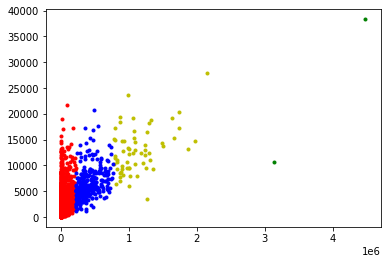

In [78]:
# Grafico los clusters para evaluar la distribucion
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'r.')
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'y.')
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'b.')
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'g.')

Text(0.5, 1.0, 'Customer in Cluster 3')

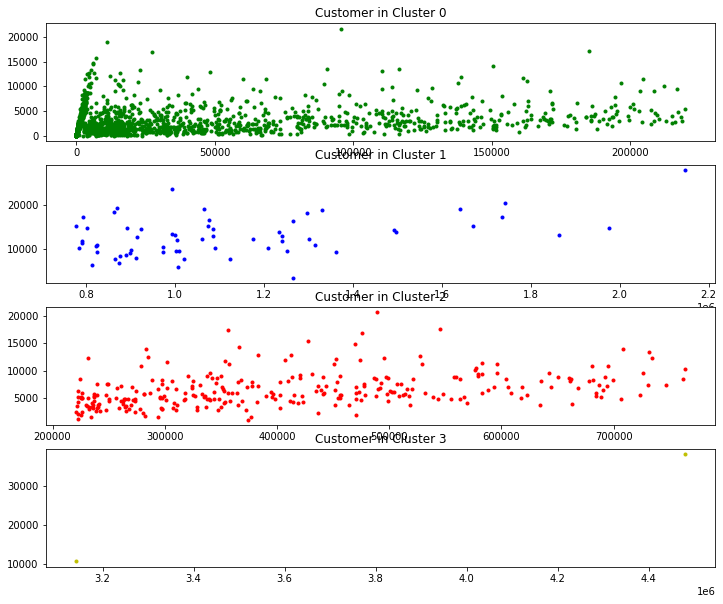

In [79]:
# Multiplot analisis
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'g.')
plt.title('Customer in Cluster 0')
plt.subplot(412)
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'b.')
plt.title('Customer in Cluster 1')
plt.subplot(413)
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'r.')
plt.title('Customer in Cluster 2')
plt.subplot(414)
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'y.')
plt.title('Customer in Cluster 3')

### Frequency & Sales Value

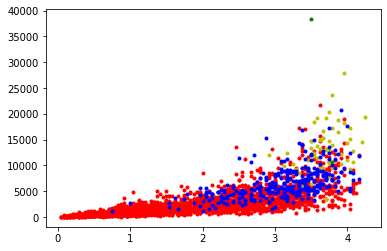

In [80]:
# Grafico los clusters para evaluar la distribucion
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'r.')
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'y.')
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'b.')
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'g.')

### Transaction Count & Sales Value

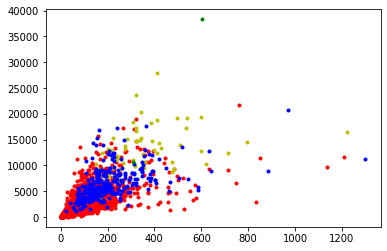

In [81]:
# Grafico los clusters para evaluar la distribucion
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'r.')
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'y.')
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'b.')
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'g.')

## Analisis demografico

En esta seccion voy a analizar cada unos de los clusters para poder evaluar sus caracteristicas.

In [87]:
# definicion de data frames para cada cluster
dna_cluster_0 = custumer_dna[custumer_dna['cluster'] == 0]
dna_cluster_1 = custumer_dna[custumer_dna['cluster'] == 1]
dna_cluster_2 = custumer_dna[custumer_dna['cluster'] == 2]
dna_cluster_3 = custumer_dna[custumer_dna['cluster'] == 3]


In [94]:
number_clients_0 = dna_cluster_0['cluster'].count()
number_clients_1 = dna_cluster_1['cluster'].count()
number_clients_2 = dna_cluster_2['cluster'].count()
number_clients_3 = dna_cluster_3['cluster'].count()

In [100]:
print("the number of users in cluster 0 are: " + str(number_clients_0) )
print("the number of users in cluster 1 are: " + str(number_clients_1) )
print("the number of users in cluster 2 are: " + str(number_clients_2) )
print("the number of users in cluster 3 are: " + str(number_clients_3) )

the number of users in cluster 0 are: 2144
the number of users in cluster 1 are: 62
the number of users in cluster 2 are: 292
the number of users in cluster 3 are: 2


### Cluster 0

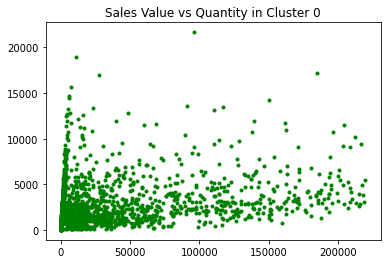

In [97]:
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'g.')
plt.title('Sales Value vs Quantity in Cluster 0')
plt.show()

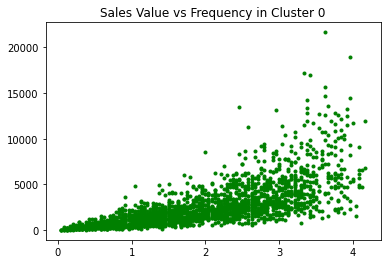

In [98]:
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'g.')
plt.title('Sales Value vs Frequency in Cluster 0')
plt.show()

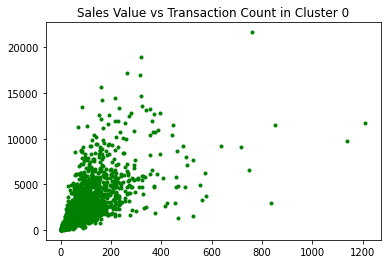

In [101]:
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 0], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 0], 'g.')
plt.title('Sales Value vs Transaction Count in Cluster 0')
plt.show()

In [120]:
dna_cluster_0.describe()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio,cluster
count,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2144.000000,2144.0
mean,89.785448,481.296642,5.175373,45.104944,29613.716418,2476.824692,1.879373,0.0
std,92.476139,373.881871,3.395673,24.207103,48617.328812,2431.654826,1.008629,0.0
min,1.000000,4.000000,1.000000,1.000000,5.000000,8.170000,0.041667,0.0
25%,34.000000,204.000000,3.000000,25.000000,615.500000,819.917500,1.041667,0.0
50%,65.000000,395.000000,4.000000,43.000000,4127.000000,1791.005000,1.791667,0.0
75%,117.000000,663.000000,7.000000,64.000000,35964.250000,3212.705000,2.666667,0.0
max,1210.000000,3119.000000,30.000000,100.000000,219680.000000,21661.290000,4.166667,0.0


### Cluster 1

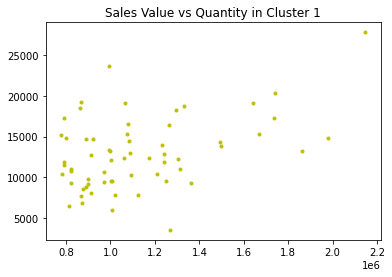

In [102]:
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'y.')
plt.title('Sales Value vs Quantity in Cluster 1')
plt.show()

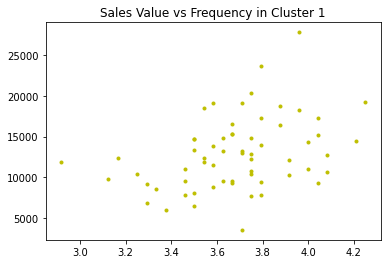

In [104]:
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'y.')
plt.title('Sales Value vs Frequency in Cluster 1')
plt.show()

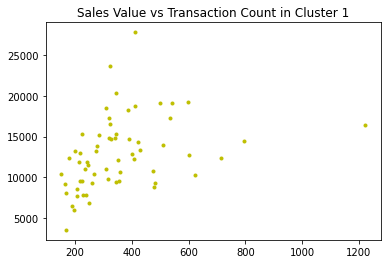

In [105]:
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 1], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 1], 'y.')
plt.title('Sales Value vs Transaction Count in Cluster 1')
plt.show()

In [121]:
dna_cluster_1.describe()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio,cluster
count,62.000000,62.000000,62.000000,62.000000,6.200000e+01,62.000000,62.000000,62.0
mean,355.483871,1464.048387,6.758065,88.290323,1.122018e+06,12880.129194,3.678763,1.0
std,179.550052,518.584341,3.317541,6.325559,3.162623e+05,4439.406050,0.263565,0.0
min,150.000000,38.000000,1.000000,70.000000,7.771320e+05,3509.780000,2.916667,1.0
25%,229.750000,1118.500000,4.250000,84.250000,8.900040e+05,9491.525000,3.510417,1.0
50%,321.500000,1405.000000,7.000000,88.500000,1.013290e+06,12392.910000,3.687500,1.0
75%,412.000000,1804.500000,9.000000,91.000000,1.260819e+06,15098.022500,3.791667,1.0
max,1223.000000,2844.000000,15.000000,102.000000,2.146715e+06,27859.680000,4.250000,1.0


### Cluster 2

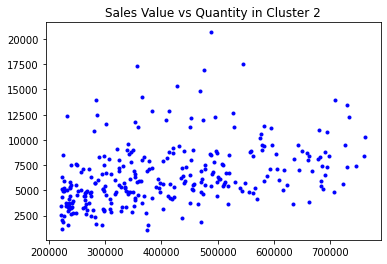

In [106]:
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'b.')
plt.title('Sales Value vs Quantity in Cluster 2')
plt.show()

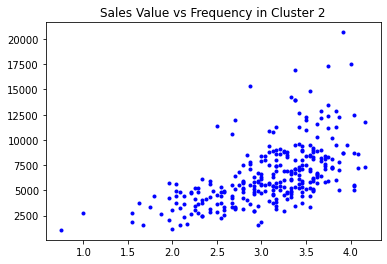

In [107]:
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'b.')
plt.title('Sales Value vs Frequency in Cluster 2')
plt.show()

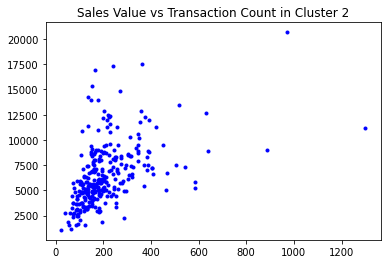

In [108]:
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 2], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 2], 'b.')
plt.title('Sales Value vs Transaction Count in Cluster 2')
plt.show()

In [122]:
dna_cluster_2.describe()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio,cluster
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.0
mean,209.020548,946.928082,7.277397,74.047945,410982.917808,6505.637295,3.085331,2.0
std,136.041103,415.271250,3.810156,14.208962,145477.149919,3072.016683,0.592040,0.0
min,23.000000,46.000000,1.000000,18.000000,221038.000000,1077.420000,0.750000,2.0
25%,133.000000,685.250000,5.000000,65.000000,286655.250000,4492.205000,2.708333,2.0
50%,177.500000,901.500000,7.000000,76.000000,377007.000000,5861.470000,3.166667,2.0
75%,247.250000,1149.500000,9.250000,85.000000,505316.750000,8097.890000,3.541667,2.0
max,1300.000000,3159.000000,20.000000,100.000000,763593.000000,20671.500000,4.166667,2.0


### Cluster 3

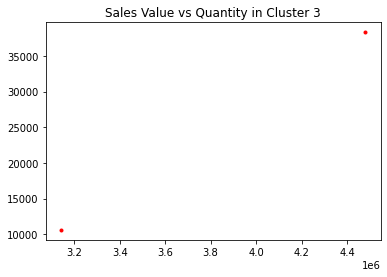

In [109]:
plt.plot(custumer_dna['QUANTITY'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'r.')
plt.title('Sales Value vs Quantity in Cluster 3')
plt.show()

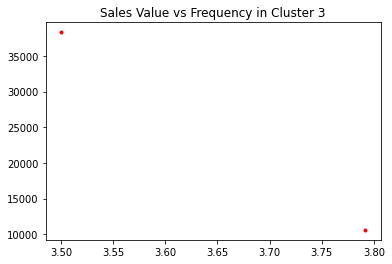

In [110]:
plt.plot(custumer_dna['frequency_ratio'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'r.')
plt.title('Sales Value vs Frequency in Cluster 3')
plt.show()

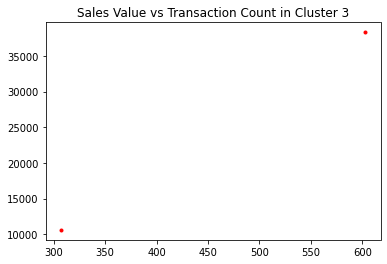

In [111]:
plt.plot(custumer_dna['Transaction_Count'][custumer_dna['cluster'] == 3], custumer_dna['SALES_VALUE'][custumer_dna['cluster'] == 3], 'r.')
plt.title('Sales Value vs Transaction Count in Cluster 3')
plt.show()

In [123]:
dna_cluster_3.describe()

,Transaction_Count,Product_Count,Store_Visit_Count,Weeks_Visited_Count,QUANTITY,SALES_VALUE,frequency_ratio,cluster
count,2.000000,2.000000,2.000000,2.000000,2.000000e+00,2.000000,2.000000,2.0
mean,455.000000,1147.500000,11.000000,87.500000,3.810843e+06,24468.420000,3.645833,3.0
std,209.303607,668.215908,1.414214,4.949747,9.462135e+05,19588.795311,0.206239,0.0
min,307.000000,675.000000,10.000000,84.000000,3.141769e+06,10617.050000,3.500000,3.0
25%,381.000000,911.250000,10.500000,85.750000,3.476306e+06,17542.735000,3.572917,3.0
50%,455.000000,1147.500000,11.000000,87.500000,3.810843e+06,24468.420000,3.645833,3.0
75%,529.000000,1383.750000,11.500000,89.250000,4.145380e+06,31394.105000,3.718750,3.0
max,603.000000,1620.000000,12.000000,91.000000,4.479917e+06,38319.790000,3.791667,3.0


## Conclución

In [142]:
print("the number of users in cluster 0 are: " + str(number_clients_0) )
print("the number of users in cluster 1 are: " + str(number_clients_1) )
print("the number of users in cluster 2 are: " + str(number_clients_2) )
print("the number of users in cluster 3 are: " + str(number_clients_3) )

the number of users in cluster 0 are: 2144
the number of users in cluster 1 are: 62
the number of users in cluster 2 are: 292
the number of users in cluster 3 are: 2


In [131]:
net_revenue_cluster0 = round(dna_cluster_0['SALES_VALUE'].sum(), 2)
total_quantity_cluster0 = round(dna_cluster_0['QUANTITY'].sum(), 2)
total_product_count_cluster0 = round(dna_cluster_0['Product_Count'].sum(), 2)
total_stores_visited_cluster0 = round(dna_cluster_0['Store_Visit_Count'].nunique(), 2)
avg_frequency_ratio = round(dna_cluster_0['frequency_ratio'].mean(), 2)
print("SUMMARY FOR CLUSTER 0:")
print("----------------------------------------------------------------")
print("The net revenue for cluster 0 is: $" + str(net_revenue_cluster0))
print("The quantity for cluster 0 is: " + str(total_quantity_cluster0))
print("The total product count for cluster 0 is: " + str(total_product_count_cluster0))
print("The number of stores visited for cluster 0 is: " + str(total_stores_visited_cluster0))
print("The avg frequency for cluster 0 is: " + str(avg_frequency_ratio) + " visits a month")

SUMMARY FOR CLUSTER 0:
----------------------------------------------------------------
The net revenue for cluster 0 is: $5310312.14
The quantity for cluster 0 is: 63491808
The total product count for cluster 0 is: 1031900
The number of stores visited for cluster 0 is: 24
The avg frequency for cluster 0 is: 1.88 visits a month


In [136]:
net_revenue_cluster1 = round(dna_cluster_1['SALES_VALUE'].sum(), 2)
total_quantity_cluster1 = round(dna_cluster_1['QUANTITY'].sum(), 2)
total_product_count_cluster1 = round(dna_cluster_1['Product_Count'].sum(), 2)
total_stores_visited_cluster1 = round(dna_cluster_1['Store_Visit_Count'].nunique(), 2)
avg_frequency_ratio1 = round(dna_cluster_1['frequency_ratio'].mean(), 2)
print("SUMMARY FOR CLUSTER 1:")
print("----------------------------------------------------------------")
print("The net revenue for cluster 1 is: $" + str(net_revenue_cluster1))
print("The quantity for cluster 1 is: " + str(total_quantity_cluster1))
print("The total product count for cluster 1 is: " + str(total_product_count_cluster1))
print("The number of stores visited for cluster 1 is: " + str(total_stores_visited_cluster1))
print("The avg frequency for cluster 1 is: " + str(avg_frequency_ratio1) + " visits a month")

SUMMARY FOR CLUSTER 1:
----------------------------------------------------------------
The net revenue for cluster 1 is: $798568.01
The quantity for cluster 1 is: 69565116
The total product count for cluster 1 is: 90771
The number of stores visited for cluster 1 is: 14
The avg frequency for cluster 1 is: 3.68 visits a month


In [139]:
net_revenue_cluster2 = round(dna_cluster_2['SALES_VALUE'].sum(), 2)
total_quantity_cluster2 = round(dna_cluster_2['QUANTITY'].sum(), 2)
total_product_count_cluster2 = round(dna_cluster_2['Product_Count'].sum(), 2)
total_stores_visited_cluster2 = round(dna_cluster_2['Store_Visit_Count'].nunique(), 2)
avg_frequency_ratio2 = round(dna_cluster_2['frequency_ratio'].mean(), 2)
print("SUMMARY FOR CLUSTER 2:")
print("----------------------------------------------------------------")
print("The net revenue for cluster 2 is: $" + str(net_revenue_cluster2))
print("The quantity for cluster 2 is: " + str(total_quantity_cluster2))
print("The total product count for cluster 2 is: " + str(total_product_count_cluster2))
print("The number of stores visited for cluster 2 is: " + str(total_stores_visited_cluster2))
print("The avg frequency for cluster 2 is: " + str(avg_frequency_ratio2) + " visits a month")

SUMMARY FOR CLUSTER 2:
----------------------------------------------------------------
The net revenue for cluster 2 is: $1899646.09
The quantity for cluster 2 is: 120007012
The total product count for cluster 2 is: 276503
The number of stores visited for cluster 2 is: 19
The avg frequency for cluster 2 is: 3.09 visits a month


In [141]:
net_revenue_cluster3 = round(dna_cluster_3['SALES_VALUE'].sum(), 2)
total_quantity_cluster3 = round(dna_cluster_3['QUANTITY'].sum(), 2)
total_product_count_cluster3 = round(dna_cluster_3['Product_Count'].sum(), 2)
total_stores_visited_cluster3 = round(dna_cluster_3['Store_Visit_Count'].nunique(), 2)
avg_frequency_ratio3 = round(dna_cluster_3['frequency_ratio'].mean(), 2)
print("SUMMARY FOR CLUSTER 3:")
print("----------------------------------------------------------------")
print("The net revenue for cluster 3 is: $" + str(net_revenue_cluster3))
print("The quantity for cluster 3 is: " + str(total_quantity_cluster3))
print("The total product count for cluster 3 is: " + str(total_product_count_cluster3))
print("The number of stores visited for cluster 3 is: " + str(total_stores_visited_cluster3))
print("The avg frequency for cluster 3 is: " + str(avg_frequency_ratio3) + " visits a month")

SUMMARY FOR CLUSTER 3:
----------------------------------------------------------------
The net revenue for cluster 3 is: $48936.84
The quantity for cluster 3 is: 7621686
The total product count for cluster 3 is: 2295
The number of stores visited for cluster 3 is: 2
The avg frequency for cluster 3 is: 3.65 visits a month


### Posibles clusters para generar promociones o descuentos

Después de haber analizado la data, entrenado el modelo de clasificación de K Means pude evaluar 4 clusters importantes. Estos clusters los evalúe en base a "elbow method" que construye distancias llamadas centroids en base de el coeficiente de inercia. En otros casos se podría usar directamente el Euclidean distance que representa la hipotenusa de un punto en relación con la predicción.

Estos 4 clusters los podría dividir en 4 categorías de clientes:

CLUSTER 0: Representa un gran porcentaje de las ventas masivas sin embargo consta con la mayor cantidad de clientes y tienen un ratio de 1.88 visitas al mes.

CLUSTER 1: Representa alrededor del 10% de las ventas en revenue sin embargo podemos ver que están más concentrados en 14 tiendas en específico y tienen una concurrencia más alta en la tienda por lo que una promoción por visitar a menudo la tienda podría ser la mejor opción.

CLUSTER 2: representa un volumen más alto de compras y está distribuido en 19 tiendas y tiene una frecuencia de visita de 3 veces al mes, podemos pensar que no hay riesgo de churn.

CLUSTER 3: Representa un volumen bajo de ventas sin embargo está relacionado a solo dos clientes que van a dos tiendas en específico con un ratio de casi 4 veces al mes. Este podría ser el tipo de cliente más valioso que probablemente esté relacionado con Business-to-business. Se le puede hacer ofertas al por mayor a estos clientes.



